In [369]:
from copulae1 import *
import os

import json
with open('../src/configs/config_coingecko_future_v3_MM.json','r') as file:
    config = json.load(file)
config
data_name = config['data_name']
calibration_method  = config['calibration_method']
OHR = pd.read_hdf('../results/'+data_name +'/'+calibration_method+'/best_h.h5')
if not os.path.exists("../results/" + data_name + "/MLE/reports"):
	print("Create new folder for results")
	os.mkdir("../results/" + data_name + "/MLE/reports")
	os.mkdir("../results/" + data_name + "/MM/reports")
    
if calibration_method == "MLE":
    report_path = "../results/" + data_name + "/MLE/reports/"
    result_path = "../results/" + data_name + "/MLE/"
elif calibration_method == "MM":
    report_path = "../results/" + data_name + "/MM/reports/"
    result_path = "../results/" + data_name + "/MM/"

In [370]:
natp_path = '../_mathematica/data/'
natp_ls = os.listdir(natp_path)
natp_h = [l for l in natp_ls if l.endswith('_h.csv')]
file_names = [l.replace('_h','') for l in natp_h]
OHR_combined = []
for i in range(len(natp_h)):
    _natp_h = pd.DataFrame(open(natp_path+natp_h[i], 'r').readlines())
    _natp_h = _natp_h.iloc[1:7,:]
    file_name = natp_h[i].replace('_h','')
    for i in range(len(_natp_h)):
        _natp_h.iloc[i,0] = np.float32(_natp_h.iloc[i,0].replace('\n',''))
    _natp_h.columns = ['NIG_factor']
    _natp_h.index = ['Variance', 'VaR q=0.01', 'VaR q=0.05', 'ES q=0.01', 'ES q=0.05', 'ERM k=10']
    _natp_h = _natp_h.T
    
    OHR_combined.append(OHR.loc[:,file_name].append(_natp_h))
OHR = pd.concat(OHR_combined, axis=1, keys=file_names).dropna(axis=1)

/Users/francis/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


In [371]:
Copula_names = ['Gaussian', 't_Copula', 'Clayton', 
               'Frank', 'Gumbel', 'Plackett', 'Gauss Mix Indep', 'NIG_factor']
OHR = OHR.loc[Copula_names,:]

In [372]:
temp = []
for C in Copula_names:
    hs_by_Copula = OHR.loc[C:C,:].melt()
    hs_by_Copula.columns = ['file_name', 'risk_measure', 'OHR']
    hs_by_Copula.loc[:, 'copula'] = C
    temp.append(hs_by_Copula)

OHR_to_math = pd.concat(temp, axis=0)

In [373]:
v5_path = '../processed_data/coingecko_future_v5/test/'
v3_path = '../processed_data/coingecko_future_v3/test/'

v5_files = os.listdir(v5_path)
v3_files = os.listdir(v3_path)

In [374]:
pd.read_csv(v5_path+'0.csv').tail()

,Unnamed: 0,Date,bitcoin price,Close,log return bitcoin,log return future
95,95,2020-09-17,10959.107673,10950.0,-0.005249,-0.005919
96,96,2020-09-16,11016.788324,11015.0,0.015720,0.018324
97,97,2020-09-15,10844.956029,10815.0,0.010277,0.010223
98,98,2020-09-14,10734.073851,10705.0,0.036930,0.034691
99,99,2020-09-11,10344.894473,10340.0,0.000183,0.002421


In [375]:
pd.read_csv(v3_path+'19.csv') 

,Unnamed: 0,Date,bitcoin price,Close,log return bitcoin,log return future
0,95,2020-09-17,10959.107673,10950.0,-0.005249,-0.005919
1,96,2020-09-16,11016.788324,11015.0,0.015720,0.018324
2,97,2020-09-15,10844.956029,10815.0,0.010277,0.010223
3,98,2020-09-14,10734.073851,10705.0,0.036930,0.034691
4,99,2020-09-11,10344.894473,10340.0,0.000183,0.002421


In [376]:
OHR_to_use = OHR_to_math.copy()
OHR_to_use.file_name = OHR_to_use.file_name.apply(lambda x: int(x.replace('.csv',''))-19) # shift file names
OHR_to_use = OHR_to_use.loc[OHR_to_use.file_name >0,:] # remove redudant rows
OHR_to_use.file_name = OHR_to_use.file_name.apply(lambda x: str(x)+'.csv')

In [377]:
risk_measure = list(OHR_to_use.risk_measure.unique())
ls = list(OHR_to_use.file_name.unique())

In [378]:
OHR_to_use.loc[:,"HE"] = 0 # Add a new column for results of HE

In [379]:
OHR_to_use.head()

,file_name,risk_measure,OHR,copula,HE
0,54.csv,ERM k=10,0.920996,Gaussian,0
1,54.csv,ES q=0.01,0.845898,Gaussian,0
2,54.csv,ES q=0.05,0.914258,Gaussian,0
3,54.csv,VaR q=0.01,0.928906,Gaussian,0
4,54.csv,VaR q=0.05,0.957031,Gaussian,0


In [380]:
def hedging_effectiveness2(rm, rs, rf, h):
    rh = rs - h*rf
    if rm == 'ERM k=10':
        return(1-ERM_estimate_trapezoidal(10, rh)/ERM_estimate_trapezoidal(10, rs))

    elif rm == 'ES q=0.01':
        return(1-ES(0.01, rh)/ES(0.01, rs))

    elif rm == 'ES q=0.05':
        return(1-ES(0.05, rh)/ES(0.05, rs))

    elif rm == 'VaR q=0.01':
        return(1-VaR(0.01, rh)/VaR(0.01, rs))

    elif rm == 'VaR q=0.05':
        return(1-VaR(0.05, rh)/VaR(0.05, rs))

    elif rm == 'Variance':
        return(1-Variance(rh)/Variance(rs))

In [381]:
def rename_rm(rm):
    rm = rm.replace('q=','')
    rm = rm.replace('0.01', '99%')
    rm = rm.replace('0.05', '95%')
    return rm

In [382]:
for i in range(len(OHR_to_use)):
    try:
        file = OHR_to_use.iloc[i,:].file_name
        rs = pd.read_csv(v5_path+file).loc[:,'log return bitcoin']
        rf = pd.read_csv(v5_path+file).loc[:,'log return future']
        h = OHR_to_use.iloc[i, :].OHR
        rm = OHR_to_use.iloc[i,:].risk_measure
        OHR_to_use.iloc[i,-1] = hedging_effectiveness2(rm, rs, rf, h)
    except:
        OHR_to_use.iloc[i,-1] = np.NAN
        print(file +' is not in ls')
        continue
OHR_to_use.dropna(inplace=True)

55.csv is not in ls
55.csv is not in ls
55.csv is not in ls
55.csv is not in ls
55.csv is not in ls
55.csv is not in ls
55.csv is not in ls
55.csv is not in ls
55.csv is not in ls
55.csv is not in ls
55.csv is not in ls
55.csv is not in ls
55.csv is not in ls
55.csv is not in ls
55.csv is not in ls
55.csv is not in ls
55.csv is not in ls
55.csv is not in ls
55.csv is not in ls
55.csv is not in ls
55.csv is not in ls
55.csv is not in ls
55.csv is not in ls
55.csv is not in ls
55.csv is not in ls
55.csv is not in ls
55.csv is not in ls
55.csv is not in ls
55.csv is not in ls
55.csv is not in ls
55.csv is not in ls
55.csv is not in ls
55.csv is not in ls
55.csv is not in ls
55.csv is not in ls
55.csv is not in ls
55.csv is not in ls
55.csv is not in ls
55.csv is not in ls
55.csv is not in ls
55.csv is not in ls
55.csv is not in ls
55.csv is not in ls
55.csv is not in ls
55.csv is not in ls
55.csv is not in ls
55.csv is not in ls
55.csv is not in ls


In [383]:
i_id = OHR_to_use.risk_measure == rm
j_id = OHR_to_use.copula == C

In [391]:
path = '../latex/_pics/hedging_effectiveness_100days_with_v3_OHR/'

for rm in risk_measure:
    i_id = OHR_to_use.risk_measure == rm
    
    plt.figure(figsize=(10,5))
    plt.title('Out-of-Sample Hedging Effectiveness of %s' %rename_rm(rm))
    
    for j, C in enumerate(Copula_names):
        j_id = OHR_to_use.copula == C
        plt.boxplot(OHR_to_use.loc[i_id&j_id,'HE'], positions=[j])
    plt.ylim((0,1))
    plt.xticks(range(len(Copula_names)), Copula_names)
    plt.savefig(path+'%s_100days_with_v3_OHR.pdf'%(rename_rm(rm).replace(' ', '_')))
    plt.close()

In [386]:
import itertools
a = ['HR 1']
b = risk_measure.copy()
c = ls.copy()
d = [1]
naive = pd.DataFrame(list(itertools.product(*[a,b,c,d])))
naive.columns = ['copula', 'risk_measure', 'file_name', 'OHR']
naive.loc[:,'HE'] = 0

In [387]:
OHR_to_use = OHR_to_use.append(naive)

/Users/francis/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


In [392]:
for i in range(len(OHR_to_use)):
    try:
        file = OHR_to_use.iloc[i,:].file_name
        rs = pd.read_csv(v5_path+file).loc[:,'log return bitcoin']
        rf = pd.read_csv(v5_path+file).loc[:,'log return future']
        h = OHR_to_use.iloc[i, :].OHR
        rm = OHR_to_use.iloc[i,:].risk_measure
        OHR_to_use.iloc[i,0] = hedging_effectiveness2(rm, rs, rf, h)
    except:
        OHR_to_use.iloc[i,-1] = np.NAN
        print(file +' is not in ls')
        continue
OHR_to_use.dropna(inplace=True)


In [397]:
path = '../latex/_pics/hedging_effectiveness_100days_with_v3_OHR_with_naive/'

for rm in risk_measure:
    i_id = OHR_to_use.risk_measure == rm
    
    plt.figure(figsize=(12,5))
    plt.title('Out-of-Sample Hedging Effectiveness of %s' %rename_rm(rm))
    
    for j, C in enumerate(Copula_names):
        j_id = OHR_to_use.copula == C
        plt.boxplot(OHR_to_use.loc[i_id&j_id,'HE'], positions=[j])
   
    j_id = OHR_to_use.copula == 'HR 1'
    plt.boxplot(OHR_to_use.loc[i_id&j_id,'HE'], positions=[j+1])
    plt.ylim((0,1))
    plt.xticks(range(len(Copula_names)+1), Copula_names+['HR 1'])
    plt.savefig(path+'%s_100days_with_v3_OHR_with_naive.pdf'%(rename_rm(rm).replace(' ', '_')))
    plt.close()


In [390]:
OHR_to_use.to_csv('../results/coingecko_future_v3/MM/hedging_effectiveness_with_v5_data_naive.csv')

In [394]:
OHR_to_use

,HE,OHR,copula,file_name,risk_measure
0,0.520462,0.920996,Gaussian,54.csv,ERM k=10
1,0.032390,0.845898,Gaussian,54.csv,ES q=0.01
2,0.419591,0.914258,Gaussian,54.csv,ES q=0.05
3,0.522977,0.928906,Gaussian,54.csv,VaR q=0.01
4,0.592582,0.957031,Gaussian,54.csv,VaR q=0.05
5,0.719560,0.907715,Gaussian,54.csv,Variance
6,0.633525,0.872266,Gaussian,17.csv,ERM k=10
7,0.508233,0.921973,Gaussian,17.csv,ES q=0.01
8,0.613762,0.88877,Gaussian,17.csv,ES q=0.05
9,0.609158,0.85791,Gaussian,17.csv,VaR q=0.01


[]

<Figure size 720x360 with 0 Axes>

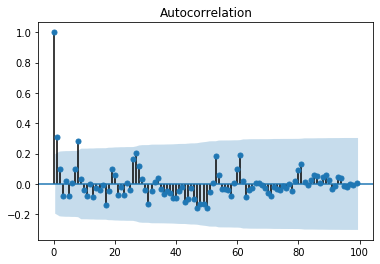

In [410]:
from statsmodels.graphics.tsaplots import plot_acf
plt.figure(figsize=(10,5))
plot_acf(np.abs(rh), lags=99)
plt.plot() # USE strong alpha mixing notation